
<h1>Spam Detection 🔎</h1>

We will be Using "SMS Spam Collection Dataset" form kaggle and build a prediction model that will classifiy wether the text is **Spam** or **Not Spam**

<h3>About Dataset 📈</h3>

Dataset contains 5,574 sms messages already tagged with spam and ham labels.

### Importing Modules

In [4]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import emoji

### Loading Data

In [5]:
# Loading Dataset
data = pd.read_csv('./data/spam.csv', encoding='ISO-8859-1')
data.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


➡️Looks like Our Dataset has some Unnamed columns and Let's Change the column name v1 and v2 to labels and text

In [6]:
# Dropping Unnamed Cols
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

# Renaming Column Names
data.rename(columns = {'v1': 'label', 'v2': 'text'}, inplace=True)

data.head(3)

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


ham     4825
spam     747
Name: label, dtype: int64


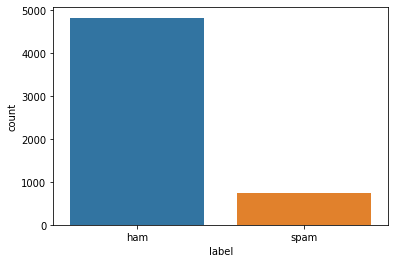

In [7]:
# Display's Value Count of Ham and Spam
print(data['label'].value_counts())

# Display Barplot
sns.countplot(x='label', data=data)
plt.show()

Our data looks to be imbalanced...
First we will clean the dataset and then balance the dataset as we don't want our model to biased towards 'Ham' labels

In [8]:
from nltk.corpus import stopwords
from collections import Counter
from tqdm.auto import tqdm
tqdm.pandas()

def clean_text(text):
  # Lowecase
  text = text.lower()
  # Remove Emoji
  text = emoji.replace_emoji(text, replace='')
  # Removes Links
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'www.\S+', '', text)
  # Remvoe Punctuations
  text = re.sub(r'[^\w\s]', '', text)
  # Remove Digits
  text = re.sub(r'[0-9]+', '', text)
  # Remove @, _
  text = text.replace('#', '').replace('_', '')
  # Removing Stopwords
  stop_words = stopwords.words('english')
  stopwords_dict = Counter(stop_words)
  text = ' '.join({word for word in text.split() if word not in stopwords_dict and len(word)>2})

  return text

data['text'] = data['text'].progress_apply(clean_text)
data.head(3)

100%|██████████| 5572/5572 [00:02<00:00, 2143.86it/s]


,label,text
0,ham,world buffet bugis available wat amore jurong ...
1,ham,joking wif oni lar
2,spam,final wkly txt apply text questionstd ratetcs ...


In [9]:
# Balancing dataset

# Seperating Ham and Spam
data_ham = data[data.label == 'ham']
data_spam = data[data.label == 'spam']

# Selecting equal ham and spam samples
data_ham = data_ham[:len(data_spam)]

print('Data Ham Shape: ', len(data_ham))
print('Data Spam Shape: ', len(data_spam))

# Combining Dataframe
balanced_data = pd.concat([data_ham, data_spam])
print('Updated Data Shape: ', data.shape)

Data Ham Shape:  747
Data Spam Shape:  747
Updated Data Shape:  (5572, 2)


# Visualizing most common words in our dataset

Now let's visualize 🖼️ most used words in ham and spam messages using python's wordcloud library

wordcloud takes entire input as a single sentence so we need to combine our messages into a single string.

In [10]:
ham_string = (' ').join(list(data_ham['text']))
spam_string = (' ').join(list(data_spam['text']))

In [11]:
# Cloud Generator
def cloud(string):
  wordcloud = WordCloud(max_words=100, background_color='white', width=800, height=400, collocations=False).generate(string)
  plt.figure(figsize=(8, 4))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

Ham


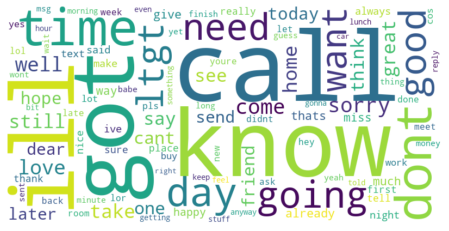

In [12]:
print('Ham')
cloud(ham_string)

Spam


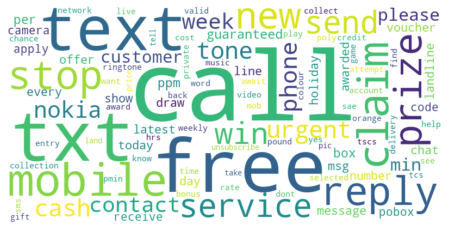

In [13]:
print('Spam')
cloud(spam_string)

# Building a Classifier

In [14]:
from sklearn.model_selection import train_test_split

# Spliting the dataset
x_train, x_test, y_train, y_test = train_test_split(balanced_data['text'], balanced_data['label'], test_size=0.3, random_state=0)

In [15]:
print('Train Shape: ', x_train.shape)
print('Test Shape: ', x_test.shape)

Train Shape:  (1045,)
Test Shape:  (449,)


In [19]:
# Our Models to Try
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

models = {
  "Logistic Regression": LogisticRegression(),
  "SVM": SVC(),
  "Linear SVM": LinearSVC(),
  "Nearest Centroid": NearestCentroid(),
  "Bernoulli NB": BernoulliNB(), 
  "Complement NB": ComplementNB(), 
  "Multinomial NB": MultinomialNB(), 
  "Preceptron": Perceptron(),
  "KNeighbors Classifier": KNeighborsClassifier(),
  "Random Forest Classifier": RandomForestClassifier(),
  "Bagging Classifier": BaggingClassifier(),
  "Decision Tree Classifier": DecisionTreeClassifier(),
  #"MLP Classifier": MLPClassifier(),
  }


In [20]:
def Classifier(models, x_train, y_train, x_test, y_test):
  models_names = []
  accuracies = []
  
  for model_name, model in models.items():
    # Convert a collection of text documents to a matrix of token counts.
    vectorizer = CountVectorizer()
    # Transform a count matrix to a normalized tf or tf-idf representation.
    tfidf = TfidfTransformer()
    # Model
    clf = model

    # Pipeline 
    pipeline = Pipeline([
      ('vec', vectorizer), 
      ('tfidf', tfidf),
      ('classifier', clf),
    ])

    pipeline.fit(x_train, y_train)
    accuracy = np.round(pipeline.score(x_test, y_test), 2)
    models_names.append(model_name)
    accuracies.append(accuracy)

  # Creating DataFrame for models and accuracys
  models_scores = pd.DataFrame(zip(models_names, accuracies), columns=['Name', 'Accuracy'])
  
  # Sorting aur table based on accuracies descending
  accuracy_table = models_scores.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)

  return accuracy_table

Classifier(models, x_train, y_train, x_test, y_test)

,Name,Accuracy
0,SVM,0.95
1,Bernoulli NB,0.95
2,Linear SVM,0.94
3,Logistic Regression,0.93
4,Complement NB,0.92
5,Multinomial NB,0.92
6,Preceptron,0.92
7,Random Forest Classifier,0.92
8,Nearest Centroid,0.90
9,KNeighbors Classifier,0.89


➡️Linear SVM performs the best, although there isnt much difference in accuricies b/w top 6 models.

In [22]:
# Training one more time on best model
from sklearn.metrics import classification_report, confusion_matrix
best_model = SVC()
vectorizer = CountVectorizer()
tfidf = TfidfTransformer()

pipeline = Pipeline([
  ('vec', vectorizer),
  ('tfidf', tfidf),
  ('classifier', best_model),
])

pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
print('Classifier Accuracy: {:.2f}%'.format(pipeline.score(x_test, y_test)))
print('Confusion Matrix: \n', confusion_matrix(y_pred, y_test))
print('Classification Report: \n', classification_report(y_test, y_pred))

Classifier Accuracy: 0.95%
Confusion Matrix: 
 [[224  20]
 [  3 202]]
Classification Report: 
               precision    recall  f1-score   support

         ham       0.92      0.99      0.95       227
        spam       0.99      0.91      0.95       222

    accuracy                           0.95       449
   macro avg       0.95      0.95      0.95       449
weighted avg       0.95      0.95      0.95       449



In [23]:
pipeline.predict(['Want to earn $1500 quick. click the link below to claim it.'])

array(['ham'], dtype=object)

In [24]:
pipeline.predict(['How are you feeling today?'])

array(['ham'], dtype=object)